In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyterrier as pt
import pandas as pd

from src.neural_ranker.ranker import NeuralRanker
from src.neural_ranker.produce_rankings import IRDataset
from main import llm_ranker, rank_with_base_model, contrastive_train_neural_ranker, rank_with_contrastive_model, pseudo_labels_fine_tune, rank_with_pseudo_labels_model
from eval import Model, evaluate_rankings

c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_mem_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    gpu_mem_reserved = torch.cuda.memory_reserved(0) / 1024**3
    gpu_mem_allocated = torch.cuda.memory_allocated(0) / 1024**3
    gpu_mem_free = gpu_mem_total - gpu_mem_reserved
    print(f"GPU Memory: Total: {gpu_mem_total:.2f}GB, Reserved: {gpu_mem_reserved:.2f}GB, "
        f"Allocated: {gpu_mem_allocated:.2f}GB, Free: {gpu_mem_free:.2f}GB")

Using device: cuda
GPU Memory: Total: 15.99GB, Reserved: 0.00GB, Allocated: 0.00GB, Free: 15.99GB


In [3]:
trec_covid = 'irds:cord19/trec-covid'

trec_covid_dataset = IRDataset(trec_covid, max_docs=None)

Loading up to None documents from irds:cord19/trec-covid...


cord19/trec-covid documents: 100%|██████████| 192509/192509 [00:00<00:00, 269205.33it/s]
Loading Documents: 192509it [00:00, 269582.29it/s]


In [16]:
rank_with_base_model(trec_covid_dataset, device)

Checking for existing embeddings...
Loaded 192509 existing document embeddings.
Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Ranking 50 queries against 192509 documents...


Ranking Queries: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


["coronavirus origin; what is the origin of COVID-19; seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans",
 'coronavirus response to weather changes; how does the coronavirus respond to changes in the weather; seeking range of information about the SARS-CoV-2 virus viability in different weather/climate conditions as well as information related to transmission of the virus in different climate conditions',
 'coronavirus immunity; will SARS-CoV2 infected people develop immunity? Is cross protection possible?; seeking studies of immunity developed due to infection with SARS-CoV2 or cross protection gained due to infection with other coronavirus types',
 'how do people die from the coronavirus; what causes death from Covid-19?; Studies looking at mechanisms of death from Covid-19.',
 'animal models of COVID-19; what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies?; Papers that

In [17]:
evaluate_rankings(model=Model.BASE, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.1859
ndcg: 0.6866
ndcg_cut_10: 0.6570
P_10: 0.6880
recall_10: 0.0165
recip_rank: 0.8403

Evaluation results saved to evaluation_results/base\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.1281
    recip_rank: 1.0000
    P_10: 0.5000
    recall_10: 0.0072
    ndcg: 0.6776
    ndcg_cut_10: 0.4959
-------------------------

Query 2:
    map: 0.0585
    recip_rank: 0.5000
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.5997
    ndcg_cut_10: 0.5527
-------------------------

Query 3:
    map: 0.1977
    recip_rank: 1.0000
    P_10: 0.9000
    recall_10: 0.0138
    ndcg: 0.7465
    ndcg_cut_10: 0.9364
-------------------------

Query 4:
    map: 0.0535
    recip_rank: 0.1000
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.5830
    ndcg_cut_10: 0.0636
-------------------------

Query 5:
    map: 0.1349
    recip_rank: 0.3333
    P_10: 0.4000
    recall_10: 

{'map': 0.18585182567772524,
 'ndcg': 0.6865586940416332,
 'ndcg_cut_10': 0.6569951008404138,
 'P_10': 0.6879999999999998,
 'recall_10': 0.01649486349187759,
 'recip_rank': 0.840343137254902}

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [28]:
contrastive_train_neural_ranker(device=device, batch_size=64, early_stop_threshold=0.01)

Loading dataset...
Loading up to None documents from irds:cord19/trec-covid...


cord19/trec-covid documents: 100%|██████████| 192509/192509 [00:00<00:00, 295815.44it/s]
Loading Documents: 192509it [00:00, 296729.04it/s]


Processing documents...


Processing documents: 100%|██████████| 192509/192509 [00:00<00:00, 4786680.91it/s]


Loaded 192509 documents for contrastive training.

Initializing augmentor...
Creating contrastive dataset...

Creating dataloader...

Dataloader configuration: batch_size=64, num_workers=0

Initializing model...
Model has 109,482,240 trainable parameters

Initializing trainer...
Training with effective batch size: 512 (batch_size=64 × accumulation_steps=8)


Epoch 1/3: 100%|██████████| 3008/3008 [07:54<00:00,  6.34it/s, loss=0.1679, mem=31.38GB]


Epoch 1/3 completed in 474.14s - Avg Loss: 0.1679
Loss improved by inf. Saving best model...


Epoch 2/3: 100%|██████████| 3008/3008 [07:38<00:00,  6.56it/s, loss=0.0540, mem=31.38GB] 


Epoch 2/3 completed in 458.58s - Avg Loss: 0.0540
Loss improved by 0.1139. Saving best model...


Epoch 3/3: 100%|██████████| 3008/3008 [08:09<00:00,  6.14it/s, loss=0.0508, mem=31.38GB] 


Epoch 3/3 completed in 489.92s - Avg Loss: 0.0508
Loss improved by 0.0032. Saving best model...
Model set to evaluation mode
Training completed in 1423.81s

Saving model to models/contrastive_model.pt...
Model saved successfully!


In [29]:
rank_with_contrastive_model(trec_covid_dataset, device)

c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\main.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ranker.load_state_dict(torch.load("mode

Checking for existing embeddings...
No existing embeddings found or file corrupted. Starting from scratch.

Processing chunk 1/39 (documents 0 to 4999)...


Encoding Chunk 1: 100%|██████████| 313/313 [00:23<00:00, 13.14it/s]



Processing chunk 2/39 (documents 5000 to 9999)...


Encoding Chunk 2: 100%|██████████| 313/313 [00:20<00:00, 15.43it/s]



Processing chunk 3/39 (documents 10000 to 14999)...


Encoding Chunk 3: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]



Processing chunk 4/39 (documents 15000 to 19999)...


Encoding Chunk 4: 100%|██████████| 313/313 [00:15<00:00, 20.37it/s]



Processing chunk 5/39 (documents 20000 to 24999)...


Encoding Chunk 5: 100%|██████████| 313/313 [00:16<00:00, 19.08it/s]



Processing chunk 6/39 (documents 25000 to 29999)...


Encoding Chunk 6: 100%|██████████| 313/313 [00:21<00:00, 14.81it/s]



Processing chunk 7/39 (documents 30000 to 34999)...


Encoding Chunk 7: 100%|██████████| 313/313 [00:24<00:00, 12.66it/s]



Processing chunk 8/39 (documents 35000 to 39999)...


Encoding Chunk 8: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]



Processing chunk 9/39 (documents 40000 to 44999)...


Encoding Chunk 9: 100%|██████████| 313/313 [00:24<00:00, 12.68it/s]



Processing chunk 10/39 (documents 45000 to 49999)...


Encoding Chunk 10: 100%|██████████| 313/313 [00:24<00:00, 12.67it/s]



Processing chunk 11/39 (documents 50000 to 54999)...


Encoding Chunk 11: 100%|██████████| 313/313 [00:24<00:00, 12.65it/s]



Processing chunk 12/39 (documents 55000 to 59999)...


Encoding Chunk 12: 100%|██████████| 313/313 [00:24<00:00, 12.87it/s]



Processing chunk 13/39 (documents 60000 to 64999)...


Encoding Chunk 13: 100%|██████████| 313/313 [00:24<00:00, 12.95it/s]



Processing chunk 14/39 (documents 65000 to 69999)...


Encoding Chunk 14: 100%|██████████| 313/313 [00:24<00:00, 12.94it/s]



Processing chunk 15/39 (documents 70000 to 74999)...


Encoding Chunk 15: 100%|██████████| 313/313 [00:24<00:00, 12.62it/s]



Processing chunk 16/39 (documents 75000 to 79999)...


Encoding Chunk 16: 100%|██████████| 313/313 [00:23<00:00, 13.38it/s]



Processing chunk 17/39 (documents 80000 to 84999)...


Encoding Chunk 17: 100%|██████████| 313/313 [00:22<00:00, 13.67it/s]



Processing chunk 18/39 (documents 85000 to 89999)...


Encoding Chunk 18: 100%|██████████| 313/313 [00:22<00:00, 13.78it/s]



Processing chunk 19/39 (documents 90000 to 94999)...


Encoding Chunk 19: 100%|██████████| 313/313 [00:20<00:00, 15.39it/s]



Processing chunk 20/39 (documents 95000 to 99999)...


Encoding Chunk 20: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]



Processing chunk 21/39 (documents 100000 to 104999)...


Encoding Chunk 21: 100%|██████████| 313/313 [00:20<00:00, 14.96it/s]



Processing chunk 22/39 (documents 105000 to 109999)...


Encoding Chunk 22: 100%|██████████| 313/313 [00:21<00:00, 14.85it/s]



Processing chunk 23/39 (documents 110000 to 114999)...


Encoding Chunk 23: 100%|██████████| 313/313 [00:20<00:00, 14.98it/s]



Processing chunk 24/39 (documents 115000 to 119999)...


Encoding Chunk 24: 100%|██████████| 313/313 [00:20<00:00, 15.05it/s]



Processing chunk 25/39 (documents 120000 to 124999)...


Encoding Chunk 25: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]



Processing chunk 26/39 (documents 125000 to 129999)...


Encoding Chunk 26: 100%|██████████| 313/313 [00:20<00:00, 15.03it/s]



Processing chunk 27/39 (documents 130000 to 134999)...


Encoding Chunk 27: 100%|██████████| 313/313 [00:21<00:00, 14.38it/s]



Processing chunk 28/39 (documents 135000 to 139999)...


Encoding Chunk 28: 100%|██████████| 313/313 [00:23<00:00, 13.42it/s]



Processing chunk 29/39 (documents 140000 to 144999)...


Encoding Chunk 29: 100%|██████████| 313/313 [00:23<00:00, 13.45it/s]



Processing chunk 30/39 (documents 145000 to 149999)...


Encoding Chunk 30: 100%|██████████| 313/313 [00:23<00:00, 13.14it/s]



Processing chunk 31/39 (documents 150000 to 154999)...


Encoding Chunk 31: 100%|██████████| 313/313 [00:23<00:00, 13.59it/s]



Processing chunk 32/39 (documents 155000 to 159999)...


Encoding Chunk 32: 100%|██████████| 313/313 [00:22<00:00, 13.65it/s]



Processing chunk 33/39 (documents 160000 to 164999)...


Encoding Chunk 33: 100%|██████████| 313/313 [00:23<00:00, 13.54it/s]



Processing chunk 34/39 (documents 165000 to 169999)...


Encoding Chunk 34: 100%|██████████| 313/313 [00:22<00:00, 13.61it/s]



Processing chunk 35/39 (documents 170000 to 174999)...


Encoding Chunk 35: 100%|██████████| 313/313 [00:22<00:00, 13.65it/s]



Processing chunk 36/39 (documents 175000 to 179999)...


Encoding Chunk 36: 100%|██████████| 313/313 [00:22<00:00, 13.61it/s]



Processing chunk 37/39 (documents 180000 to 184999)...


Encoding Chunk 37: 100%|██████████| 313/313 [00:22<00:00, 13.71it/s]



Processing chunk 38/39 (documents 185000 to 189999)...


Encoding Chunk 38: 100%|██████████| 313/313 [00:23<00:00, 13.49it/s]



Processing chunk 39/39 (documents 190000 to 192508)...


Encoding Chunk 39: 100%|██████████| 157/157 [00:11<00:00, 13.87it/s]


Completed processing 192509 documents.
Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Ranking 50 queries against 192509 documents...


Ranking Queries: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]


In [30]:
evaluate_rankings(model=Model.CONTRASTIVE, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.0655
ndcg: 0.5749
ndcg_cut_10: 0.3025
P_10: 0.3360
recall_10: 0.0066
recip_rank: 0.5102

Evaluation results saved to evaluation_results/contrastive\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.1500
    recip_rank: 1.0000
    P_10: 0.7000
    recall_10: 0.0100
    ndcg: 0.7027
    ndcg_cut_10: 0.6888
-------------------------

Query 2:
    map: 0.1948
    recip_rank: 0.5000
    P_10: 0.8000
    recall_10: 0.0239
    ndcg: 0.7070
    ndcg_cut_10: 0.6350
-------------------------

Query 3:
    map: 0.0285
    recip_rank: 0.1667
    P_10: 0.1000
    recall_10: 0.0015
    ndcg: 0.5493
    ndcg_cut_10: 0.0784
-------------------------

Query 4:
    map: 0.0122
    recip_rank: 0.0357
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4899
    ndcg_cut_10: 0.0000
-------------------------

Query 5:
    map: 0.0293
    recip_rank: 0.0400
    P_10: 0.0000
    reca

{'map': 0.06553374788151343,
 'ndcg': 0.5749276606849775,
 'ndcg_cut_10': 0.30253051487755983,
 'P_10': 0.336,
 'recall_10': 0.00661036753681336,
 'recip_rank': 0.5102068848595982}

In [13]:
%autoreload
pseudo_labels_fine_tune(dataset=trec_covid_dataset, device=device)

Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
topics:    qid                                          title  \
0    1                             coronavirus origin   
1    2        coronavirus response to weather changes   
2    3                           coronavirus immunity   
3    4         how do people die from the coronavirus   
4    5                      animal models of COVID-19   
5    6                 coronavirus test rapid testing   
6    7              serological tests for coronavirus   
7    8                    coronavirus under reporting   
8    9                          coronavirus in Canada   
9   10           coronavirus social distancing impact   
10  11                 coronavirus hospital rationing   
11  12                         coronavirus quarantine   
12  13                    how does cor

In [14]:
rank_with_pseudo_labels_model(trec_covid_dataset, device)

c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\main.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ranker.load_state_dict(torch.load("mode

Checking for existing embeddings...
No existing embeddings found or file corrupted. Starting from scratch.

Processing chunk 1/39 (documents 0 to 4999)...


Encoding Chunk 1: 100%|██████████| 313/313 [00:24<00:00, 12.63it/s]



Processing chunk 2/39 (documents 5000 to 9999)...


Encoding Chunk 2: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]



Processing chunk 3/39 (documents 10000 to 14999)...


Encoding Chunk 3: 100%|██████████| 313/313 [00:20<00:00, 15.49it/s]



Processing chunk 4/39 (documents 15000 to 19999)...


Encoding Chunk 4: 100%|██████████| 313/313 [00:15<00:00, 19.91it/s]



Processing chunk 5/39 (documents 20000 to 24999)...


Encoding Chunk 5: 100%|██████████| 313/313 [00:17<00:00, 18.00it/s]



Processing chunk 6/39 (documents 25000 to 29999)...


Encoding Chunk 6: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s]



Processing chunk 7/39 (documents 30000 to 34999)...


Encoding Chunk 7: 100%|██████████| 313/313 [00:24<00:00, 12.67it/s]



Processing chunk 8/39 (documents 35000 to 39999)...


Encoding Chunk 8: 100%|██████████| 313/313 [00:24<00:00, 12.73it/s]



Processing chunk 9/39 (documents 40000 to 44999)...


Encoding Chunk 9: 100%|██████████| 313/313 [00:24<00:00, 12.86it/s]



Processing chunk 10/39 (documents 45000 to 49999)...


Encoding Chunk 10: 100%|██████████| 313/313 [00:24<00:00, 12.84it/s]



Processing chunk 11/39 (documents 50000 to 54999)...


Encoding Chunk 11: 100%|██████████| 313/313 [00:24<00:00, 12.84it/s]



Processing chunk 12/39 (documents 55000 to 59999)...


Encoding Chunk 12: 100%|██████████| 313/313 [00:24<00:00, 12.90it/s]



Processing chunk 13/39 (documents 60000 to 64999)...


Encoding Chunk 13: 100%|██████████| 313/313 [00:24<00:00, 12.85it/s]



Processing chunk 14/39 (documents 65000 to 69999)...


Encoding Chunk 14: 100%|██████████| 313/313 [00:24<00:00, 12.87it/s]



Processing chunk 15/39 (documents 70000 to 74999)...


Encoding Chunk 15: 100%|██████████| 313/313 [00:24<00:00, 12.91it/s]



Processing chunk 16/39 (documents 75000 to 79999)...


Encoding Chunk 16: 100%|██████████| 313/313 [00:23<00:00, 13.16it/s]



Processing chunk 17/39 (documents 80000 to 84999)...


Encoding Chunk 17: 100%|██████████| 313/313 [00:23<00:00, 13.45it/s]



Processing chunk 18/39 (documents 85000 to 89999)...


Encoding Chunk 18: 100%|██████████| 313/313 [00:23<00:00, 13.59it/s]



Processing chunk 19/39 (documents 90000 to 94999)...


Encoding Chunk 19: 100%|██████████| 313/313 [00:21<00:00, 14.83it/s]



Processing chunk 20/39 (documents 95000 to 99999)...


Encoding Chunk 20: 100%|██████████| 313/313 [00:21<00:00, 14.76it/s]



Processing chunk 21/39 (documents 100000 to 104999)...


Encoding Chunk 21: 100%|██████████| 313/313 [00:21<00:00, 14.82it/s]



Processing chunk 22/39 (documents 105000 to 109999)...


Encoding Chunk 22: 100%|██████████| 313/313 [00:21<00:00, 14.51it/s]



Processing chunk 23/39 (documents 110000 to 114999)...


Encoding Chunk 23: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]



Processing chunk 24/39 (documents 115000 to 119999)...


Encoding Chunk 24: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]



Processing chunk 25/39 (documents 120000 to 124999)...


Encoding Chunk 25: 100%|██████████| 313/313 [00:21<00:00, 14.83it/s]



Processing chunk 26/39 (documents 125000 to 129999)...


Encoding Chunk 26: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]



Processing chunk 27/39 (documents 130000 to 134999)...


Encoding Chunk 27: 100%|██████████| 313/313 [00:21<00:00, 14.30it/s]



Processing chunk 28/39 (documents 135000 to 139999)...


Encoding Chunk 28: 100%|██████████| 313/313 [00:23<00:00, 13.44it/s]



Processing chunk 29/39 (documents 140000 to 144999)...


Encoding Chunk 29: 100%|██████████| 313/313 [00:23<00:00, 13.42it/s]



Processing chunk 30/39 (documents 145000 to 149999)...


Encoding Chunk 30: 100%|██████████| 313/313 [00:23<00:00, 13.24it/s]



Processing chunk 31/39 (documents 150000 to 154999)...


Encoding Chunk 31: 100%|██████████| 313/313 [00:23<00:00, 13.33it/s]



Processing chunk 32/39 (documents 155000 to 159999)...


Encoding Chunk 32: 100%|██████████| 313/313 [00:23<00:00, 13.40it/s]



Processing chunk 33/39 (documents 160000 to 164999)...


Encoding Chunk 33: 100%|██████████| 313/313 [00:23<00:00, 13.33it/s]



Processing chunk 34/39 (documents 165000 to 169999)...


Encoding Chunk 34: 100%|██████████| 313/313 [00:23<00:00, 13.19it/s]



Processing chunk 35/39 (documents 170000 to 174999)...


Encoding Chunk 35: 100%|██████████| 313/313 [00:23<00:00, 13.23it/s]



Processing chunk 36/39 (documents 175000 to 179999)...


Encoding Chunk 36: 100%|██████████| 313/313 [00:23<00:00, 13.34it/s]



Processing chunk 37/39 (documents 180000 to 184999)...


Encoding Chunk 37: 100%|██████████| 313/313 [00:23<00:00, 13.36it/s]



Processing chunk 38/39 (documents 185000 to 189999)...


Encoding Chunk 38: 100%|██████████| 313/313 [00:23<00:00, 13.17it/s]



Processing chunk 39/39 (documents 190000 to 192508)...


Encoding Chunk 39: 100%|██████████| 157/157 [00:11<00:00, 13.24it/s]


Completed processing 192509 documents.
Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Ranking 50 queries against 192509 documents...


Ranking Queries: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


In [15]:
evaluate_rankings(model=Model.PSEUDO_LABELS, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.0322
ndcg: 0.5071
ndcg_cut_10: 0.4170
P_10: 0.4360
recall_10: 0.0106
recip_rank: 0.6488

Evaluation results saved to evaluation_results/pseudo_labels\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0156
    recip_rank: 1.0000
    P_10: 0.1000
    recall_10: 0.0014
    ndcg: 0.5221
    ndcg_cut_10: 0.2201
-------------------------

Query 2:
    map: 0.0086
    recip_rank: 0.0179
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4572
    ndcg_cut_10: 0.0000
-------------------------

Query 3:
    map: 0.0969
    recip_rank: 0.5000
    P_10: 0.7000
    recall_10: 0.0107
    ndcg: 0.6311
    ndcg_cut_10: 0.5757
-------------------------

Query 4:
    map: 0.0048
    recip_rank: 0.0114
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4450
    ndcg_cut_10: 0.0000
-------------------------

Query 5:
    map: 0.0271
    recip_rank: 0.5000
    P_10: 0.2000
    re

{'map': 0.03215021909606651,
 'ndcg': 0.5070651021818885,
 'ndcg_cut_10': 0.4170217740965713,
 'P_10': 0.4359999999999999,
 'recall_10': 0.010600528170024815,
 'recip_rank': 0.6487659631270382}

In [31]:
llm_ranker(trec_covid_dataset)

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Zero: Query 1 and Docno 1mjaycee processed. Result: 180.5
Few: Query 1 and Docno 1mjaycee processed. Result: 190.567
Zero: Query 1 and Docno nm2ubi13 processed. Result: 165.5
Few: Query 1 and Docno nm2ubi13 processed. Result: 175.329
Zero: Query 1 and Docno aeogp8c7 processed. Result: 175.5
Few: Query 1 and Docno aeogp8c7 processed. Result: 174.826
Zero: Query 1 and Docno k9lcpjyo processed. Result: 140.5
Few: Query 1 and Docno k9lcpjyo processed. Result: 175.892
Zero: Query 1 and Docno zxudiyj4 processed. Result: 178.5
Few: Query 1 and Docno zxudiyj4 processed. Result: 187.543
Zero: Query 1 and Docno mo4luyx6 processed. Result: 175.5
Few: Query 1 and Docno mo4luyx6 processed. Result: 188.765
Zero: Query 1 and Docno o4njvi62 processed. Result: 100.5
Few: Query 1 and Docno o4njvi62 processed. Result: 155.789
Zero: Query 1 and D

In [4]:
dataframe_few = pd.read_csv('rankings/llm_few_rankings_unsorted.csv')
dataframe_zero = pd.read_csv('rankings/llm_zero_rankings_unsorted.csv')

df_top100_few_sorted = (
    dataframe_few
    .sort_values(by=["qid", "score"], ascending=[True, False])
    .reset_index(drop=True)
)

df_top100_zero_sorted = (
    dataframe_zero
    .sort_values(by=["qid", "score"], ascending=[True, False])
    .reset_index(drop=True)
)

# Save the sorted DataFrame to a CSV file
df_top100_few_sorted.to_csv('rankings/llm_few_rankings.csv', index=False)
df_top100_zero_sorted.to_csv('rankings/llm_zero_rankings.csv', index=False)

In [6]:
evaluate_rankings(model=Model.LLMZERO, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 4530 ranking entries

=== Evaluation Results ===
map: 0.0657
ndcg: 0.1525
ndcg_cut_10: 0.6146
P_10: 0.6740
recall_10: 0.0155
recip_rank: 0.8413

Evaluation results saved to evaluation_results/llm_zero\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0391
    recip_rank: 1.0000
    P_10: 0.8000
    recall_10: 0.0114
    ndcg: 0.1008
    ndcg_cut_10: 0.5819
-------------------------

Query 2:
    map: 0.0371
    recip_rank: 1.0000
    P_10: 0.8000
    recall_10: 0.0239
    ndcg: 0.1224
    ndcg_cut_10: 0.7582
-------------------------

Query 3:
    map: 0.0657
    recip_rank: 1.0000
    P_10: 0.8000
    recall_10: 0.0123
    ndcg: 0.1831
    ndcg_cut_10: 0.7195
-------------------------

Query 4:
    map: 0.0082
    recip_rank: 0.2000
    P_10: 0.3000
    recall_10: 0.0053
    ndcg: 0.0443
    ndcg_cut_10: 0.1557
-------------------------

Query 5:
    map: 0.0128
    recip_rank: 0.2000
    P_10: 0.2000
    recall_10:

{'map': 0.06573805048335087,
 'ndcg': 0.1524508984967312,
 'ndcg_cut_10': 0.6145938467723788,
 'P_10': 0.674,
 'recall_10': 0.015536760198382255,
 'recip_rank': 0.8413333333333334}

In [8]:
evaluate_rankings(model=Model.LLMFEW, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 4530 ranking entries

=== Evaluation Results ===
map: 0.0653
ndcg: 0.1523
ndcg_cut_10: 0.6203
P_10: 0.6740
recall_10: 0.0155
recip_rank: 0.8250

Evaluation results saved to evaluation_results/llm_few\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0313
    recip_rank: 0.5000
    P_10: 0.6000
    recall_10: 0.0086
    ndcg: 0.0870
    ndcg_cut_10: 0.2904
-------------------------

Query 2:
    map: 0.0345
    recip_rank: 0.3333
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.1094
    ndcg_cut_10: 0.5080
-------------------------

Query 3:
    map: 0.0646
    recip_rank: 1.0000
    P_10: 0.7000
    recall_10: 0.0107
    ndcg: 0.1816
    ndcg_cut_10: 0.6777
-------------------------

Query 4:
    map: 0.0080
    recip_rank: 0.3333
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.0423
    ndcg_cut_10: 0.0550
-------------------------

Query 5:
    map: 0.0176
    recip_rank: 0.3333
    P_10: 0.4000
    recall_10: 

{'map': 0.0652625023756733,
 'ndcg': 0.152312427973996,
 'ndcg_cut_10': 0.6202638845508817,
 'P_10': 0.674,
 'recall_10': 0.015520176260792155,
 'recip_rank': 0.825}

In [4]:
base_results = pd.read_csv('evaluation_results/base/evaluation_results.csv')
contrastive_results = pd.read_csv('evaluation_results/contrastive/evaluation_results.csv')
pseudo_labels_results = pd.read_csv('evaluation_results/pseudo_labels/evaluation_results.csv')
llm_zero_results = pd.read_csv('evaluation_results/llm_zero/evaluation_results.csv')
llm_few_results = pd.read_csv('evaluation_results/llm_few/evaluation_results.csv')

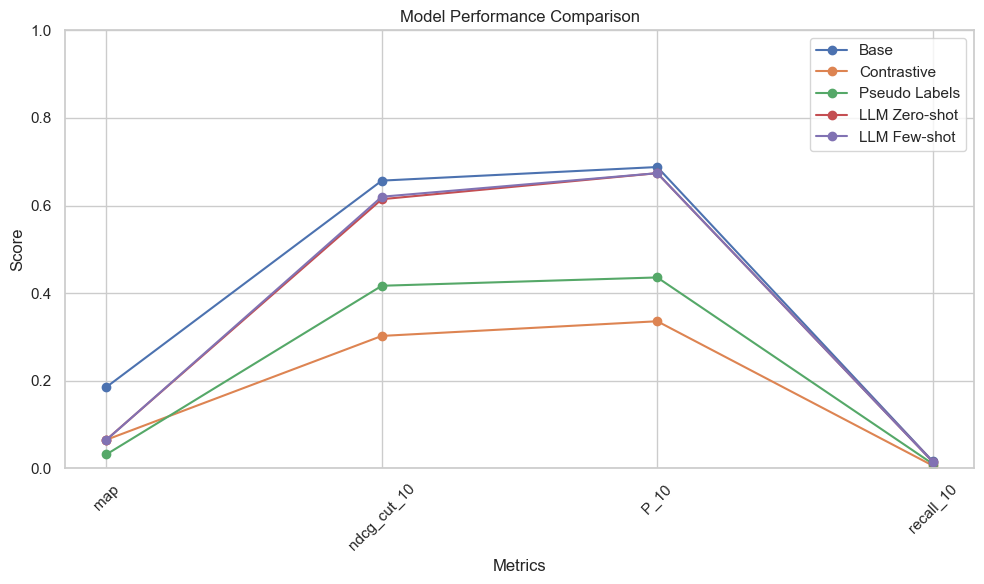

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['map', 'ndcg_cut_10', 'P_10', 'recall_10']

# create a line for each model that goes through the metrics results
# and add the model name as a label
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for model_results, label in zip([base_results, contrastive_results, pseudo_labels_results, llm_zero_results, llm_few_results], ['Base', 'Contrastive', 'Pseudo Labels', 'LLM Zero-shot', 'LLM Few-shot']):
    plt.plot(metrics, model_results[metrics].values.flatten(), marker='o', label=label)

plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
base_rankings = pd.read_csv('rankings/base_rankings.csv')
contrastive_rankings = pd.read_csv('rankings/contrastive_rankings.csv')
pseudo_labels_rankings = pd.read_csv('rankings/pseudo_labels_rankings.csv')

In [10]:
def get_top_k_rankings(df, k=10):
    """
    Get the top k rankings for each query ID.
    """
    # Sort the DataFrame by 'qid' and 'score' in descending order
    sorted_df = df.sort_values(by=['query_id', 'score'], ascending=[True, False])
    
    # Group by 'qid' and get the top k rows for each group
    top_k_df = sorted_df.groupby('query_id').head(k)
    
    return top_k_df

In [14]:
top_100_base_rankings = get_top_k_rankings(base_rankings, k=100)
top_100_contrastive_rankings = get_top_k_rankings(contrastive_rankings, k=100)
top_100_pseudo_labels_rankings = get_top_k_rankings(pseudo_labels_rankings, k=100)

# Save the top 100 rankings to CSV files
top_100_base_rankings.to_csv('rankings/top_100_base_rankings.csv', index=False)
top_100_contrastive_rankings.to_csv('rankings/top_100_contrastive_rankings.csv', index=False)
top_100_pseudo_labels_rankings.to_csv('rankings/top_100_pseudo_labels_rankings.csv', index=False)


In [15]:
evaluate_rankings(model=Model.TOP_100_BASE, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 5000 ranking entries

=== Evaluation Results ===
map: 0.0707
ndcg: 0.1671
ndcg_cut_10: 0.6574
P_10: 0.6880
recall_10: 0.0165
recip_rank: 0.8403

Evaluation results saved to evaluation_results/top_100_base\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0277
    recip_rank: 1.0000
    P_10: 0.5000
    recall_10: 0.0072
    ndcg: 0.0961
    ndcg_cut_10: 0.4959
-------------------------

Query 2:
    map: 0.0255
    recip_rank: 0.5000
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.1057
    ndcg_cut_10: 0.5527
-------------------------

Query 3:
    map: 0.0762
    recip_rank: 1.0000
    P_10: 0.9000
    recall_10: 0.0138
    ndcg: 0.1982
    ndcg_cut_10: 0.9364
-------------------------

Query 4:
    map: 0.0046
    recip_rank: 0.1000
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.0374
    ndcg_cut_10: 0.0636
-------------------------

Query 5:
    map: 0.0157
    recip_rank: 0.3333
    P_10: 0.4000
    recall

{'map': 0.07073416754980412,
 'ndcg': 0.16708769857809636,
 'ndcg_cut_10': 0.6574213129589601,
 'P_10': 0.6879999999999998,
 'recall_10': 0.01649486349187759,
 'recip_rank': 0.840343137254902}

In [16]:
evaluate_rankings(model=Model.TOP_100_CONTRASTIVE, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 5000 ranking entries

=== Evaluation Results ===
map: 0.0166
ndcg: 0.0628
ndcg_cut_10: 0.3025
P_10: 0.3360
recall_10: 0.0066
recip_rank: 0.5100

Evaluation results saved to evaluation_results/top_100_contrastive\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0360
    recip_rank: 1.0000
    P_10: 0.7000
    recall_10: 0.0100
    ndcg: 0.1144
    ndcg_cut_10: 0.6888
-------------------------

Query 2:
    map: 0.0860
    recip_rank: 0.5000
    P_10: 0.8000
    recall_10: 0.0239
    ndcg: 0.1999
    ndcg_cut_10: 0.6350
-------------------------

Query 3:
    map: 0.0017
    recip_rank: 0.1667
    P_10: 0.1000
    recall_10: 0.0015
    ndcg: 0.0234
    ndcg_cut_10: 0.0784
-------------------------

Query 4:
    map: 0.0001
    recip_rank: 0.0357
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.0031
    ndcg_cut_10: 0.0000
-------------------------

Query 5:
    map: 0.0003
    recip_rank: 0.0400
    P_10: 0.0000
   

{'map': 0.01663079088083883,
 'ndcg': 0.0627900394680943,
 'ndcg_cut_10': 0.30253051487755983,
 'P_10': 0.336,
 'recall_10': 0.00661036753681336,
 'recip_rank': 0.5100028032269451}

In [17]:
evaluate_rankings(model=Model.TOP_100_PSEUDO_LABELS, dataset_name=trec_covid)

Evaluating rankings with metrics@10...
Loaded 5000 ranking entries

=== Evaluation Results ===
map: 0.0217
ndcg: 0.0701
ndcg_cut_10: 0.4170
P_10: 0.4360
recall_10: 0.0106
recip_rank: 0.6486

Evaluation results saved to evaluation_results/top_100_pseudo_labels\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0019
    recip_rank: 1.0000
    P_10: 0.1000
    recall_10: 0.0014
    ndcg: 0.0213
    ndcg_cut_10: 0.2201
-------------------------

Query 2:
    map: 0.0006
    recip_rank: 0.0179
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.0170
    ndcg_cut_10: 0.0000
-------------------------

Query 3:
    map: 0.0471
    recip_rank: 0.5000
    P_10: 0.7000
    recall_10: 0.0107
    ndcg: 0.1394
    ndcg_cut_10: 0.5757
-------------------------

Query 4:
    map: 0.0000
    recip_rank: 0.0114
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.0013
    ndcg_cut_10: 0.0000
-------------------------

Query 5:
    map: 0.0067
    recip_rank: 0.5000
    P_10: 0.2000
 

{'map': 0.021747619510330406,
 'ndcg': 0.07008770664029741,
 'ndcg_cut_10': 0.4170217740965713,
 'P_10': 0.4359999999999999,
 'recall_10': 0.010600528170024815,
 'recip_rank': 0.6486172438672437}

In [18]:
top_100_base_results = pd.read_csv('evaluation_results/top_100_base/evaluation_results.csv')
top_100_contrastive_results = pd.read_csv('evaluation_results/top_100_contrastive/evaluation_results.csv')
top_100_pseudo_labels_results = pd.read_csv('evaluation_results/top_100_pseudo_labels/evaluation_results.csv')
llm_few_results = pd.read_csv('evaluation_results/llm_few/evaluation_results.csv')
llm_zero_results = pd.read_csv('evaluation_results/llm_zero/evaluation_results.csv')

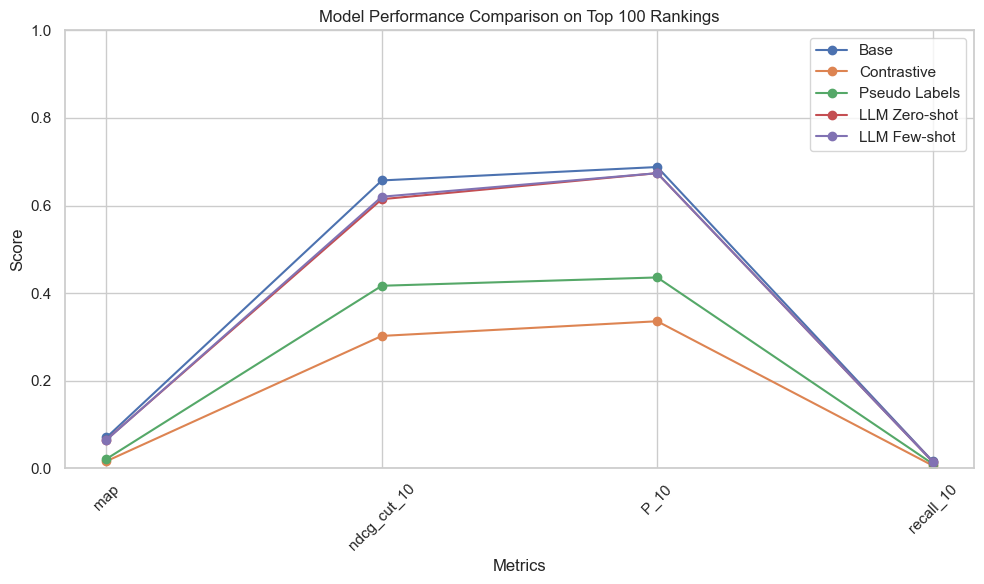

In [20]:
metrics = ['map', 'ndcg_cut_10', 'P_10', 'recall_10']

# create a line for each model that goes through the metrics results
# and add the model name as a label
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for model_results, label in zip([top_100_base_results, top_100_contrastive_results, top_100_pseudo_labels_results, llm_zero_results, llm_few_results], ['Base', 'Contrastive', 'Pseudo Labels', 'LLM Zero-shot', 'LLM Few-shot']):
    plt.plot(metrics, model_results[metrics].values.flatten(), marker='o', label=label)

plt.title('Model Performance Comparison on Top 100 Rankings')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()